# GHZ simulation with FockStateCircuit
We show how to use the class 'FockStateCircuit' to simulate the GHZ state creation as first demonstrated by Bouwmeester et al (see citation in references)

## References
Dik Bouwmeester, Jian-Wei Pan, Matthew Daniell, Harald Weinfurter, and Anton Zeilinger
Phys. Rev. Lett. 82, 1345 – Published 15 February 1999

Greenberger, Daniel M.; Horne, Michael A.; Zeilinger, Anton (1989). "Going beyond Bell's Theorem". In Kafatos, M. (ed.). Bell's Theorem, Quantum Theory and Conceptions of the Universe. Dordrecht: Kluwer. p. 69.

## Load the required module(s)

In [1]:
import sys  
sys.path.append("../src")
import fock_state_circuit as fsc
import collection_of_states as cos
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

## What is a GHZ state?
The abbreviation GHZ stands for the names of the scientist who first pubished on entanglement between multiple (more that two) particles. These were Daniel Greenberger, Michael Horne and Anton Zeilinger in 1989. Entanglement between two particles has been considered since the early days for quantum theory. In 1935 Erwin Schrodinger famously considered it the defining characteristic of quantum theory "I would not call that [i.e. entanglement] one but rather the characteristic trait of quantum mechanics, the one that enforces its entire departure from classical lines of thought."

In their 1989 paper (see references) Greenberger, Horne and Zeilinger considered entanglement between 4 particles to demonstrate more clearly non-classical correlations between entangled particles. Where in the orginal EPR experiments you still need statistics to demonstrate quantum effects, with a GHZ state this can be done without statistics. 

The first creation of a GHZ state was reported by Bouwmeester and co-workers (from the group of Anton Zeilinger in Austria). In this post we replicate that experiment in Python, using the class FockStateCircuit that was specifically developed for modelling quantum optical experiments.

Further information and refences can be found in the 'Scientific Background' as published by the Nobel Prize committee for their 2022 award announcement: https://www.nobelprize.org/uploads/2022/10/advanced-physicsprize2022-3.pdf

## The Bouwmeester experiment

### Experimental setup
![title](../images/GHZ-Fig1.png) 

Figure 1 is the original sketch from the Bouwmeester article with added some elements to clarify the naming used in this notebook. We will work with a wave function consisting of 8 Fock states representing 4  'spatial channels'. These 4 'spatial channels' carry two channels each (horizontal and vertical polarization), so there are 8 channels in total. Initially these will be 8 vacuum states (i.e., no photons present). Ultimately 4 of these channels will be detected by the detectors (called 'trigger', 'D1', 'D2' and 'D3' by the authors). The other ones are absorbed by the polarizers in front of the detectors, or never populated in the first place (the vertically polarized channel leading to detector 'T' only couples with the vacuum port of the polarizing beamsplitter, so will never carry a photon).

In software we can follow the evolution of the initial state through the system. For this we added the labels 'c', 'd' and 'e' to the spatial channels as indicated in the figure. 

We start with a state in the basis $|ah>|av>|bh>|bv>|BSh>|BSv>|PBSh>|PBSv>$. Here for instance $|ah>$ represents a Fock state which can contain 0,1,2,3 or 4 photons. Note that these are Fock states and not Qubits. The number represents the number of photons in the state. If we would for instance have state $|20000000>$, if means two photons in 'channel a' with horizontal polarization. State $|00000000>$ represents the state with all channels in the vacuum states (i.e., no photons).

After the optical system the basis is $|Th>|Tv>|D3h>|D3v>|D1h>|D1v>|D2h>|D2v>$. If we consider detection at +45 degree or -45 degree the final basis would be $|Th>|Tv>|D3+>|D3->|D1+>|D1->|D2+>|D2->$. The order of the final basis is chosen for convenience because in simulation we keep the same channel number for light passing straight through a beamsplitter. In the schematics of the experimental setup there is a straight line from channel 'a' to the trigger detector, hence they have the same number. We could easily add some swap gates but this will only add complexity, hence we choose to use the 'illogical' order of the basis. Below picture shows how the channel numbers map on the experiment.

![title](../images/Channel-Layout-GHZ-Simulation.png)



### Entanglement

The system start with two pairs of entangled photons in 'channel a' and 'channel b'. for each pair the entangled state is written as:

![title](../images/Eq1-Bouwmeester-PRL-15feb1999.png)

In our code we would write the state for one photon pair as $\frac{1}{\sqrt{2}}\cdot(|10010000> - |01100000>)$ (using basis $|ah>|av>|bh>|bv>|BSh>|BSv>|PBSh>|PBSv>$). The initial state for the two photon pairs would be $\frac{1}{2}\cdot(|20020000> + |02200000> - 2|11110000>)$. In the experiment we will only count a result of we detect a photon at the trigger and at the three detectors. This means that the components $|20020000>$ and $|20020000>$ will be discarded as they either do not lead to a photon the trigger, or to two photons at the trigger (channel 'ah' passes straight through the polarizing beamsplitter to the trigger). The only component in the initial state that leads to exactly one photon at the trigger is $|11110000>$. So in our simulation we take the initial state $|11110000>$ to avoid spending calculation resources on the other components, knowing the results will be discarded anyway.

The resulting GHZ state after the optical system, just before the detectors, is written as

![title](../images/Eq4-Bouwmeester-PRL-15feb1999.png)

In our code we would write this state as $\frac{1}{\sqrt{2}}\cdot(|10011010> + |10100101>)$ (using basis $|Th>|Tv>|D3h>|D3v>|D1h>|D1v>|D2h>|D2v>$). Note that we still include the state of trigger channel ('Th') which is not part of the entanglement and could be factored out. The condition for detecting the GHZ state is that one photon in the trigger channel is detected.

Once GHZ state is created the correlation experiment is performed. We want to analyze correlations that proof the three-photon entanglement. We should realize that if we simply detect one photon in either horizontal or vertical polarization the entangled state collapses to a single component. So if we consider the situation where the polarizer in channel 1 is oriented at 0 degree (so passes the 'H' polarization and rejects the 'V' polarization). Then, when a photon is detected we know it was horizontally polarized in channel 1 and the GHZ state has to collaps to horizontal in channel 1 and 2, and vertical in channel 3. In our code we would see the GHZ state (written as $\frac{1}{\sqrt{2}}\cdot(|10011010> + |10100101>)$) collaps into the state written as $|10011010>$. A horizontally polarized photon for detector 1 is represented by a '1' in channel 4, so only the component with this value will remain after collapse of the wave function (remember we work in the basis $|Th>|Tv>|D3h>|D3v>|D1h>|D1v>|D2h>|D2v>$). There is no entanglement anymore and the polarization of the photons for detectors 2 and 3 are fully known (horizontal for detector 2 and vertical for detector 3). If we would measure channels 2 and 3 at 45 degree we would see no correlation between the results. 

However, If we project 'channel 1' on an angle of +45 degree by a polarizer the situation is different. If a photon is detected (at this angel of 45 degree) then the resulting state is written as

![title](../images/Eq12-Bouwmeester-PRL-15feb1999.png)

In our code this would be written as $\frac{1}{\sqrt{2}}\cdot(|10011010> + |10101001>)$ (using basis $|Th>|Tv>|D3h>|D3v>|D1+>|D1->|D2h>|D2v>$, note that we switch for D1 from basis $|D1h>|D1v>$ to $|D1+>|D1->$ since we rotated the polarization detection direction). Clearly now the photons in channel 2 and channel 3 are fully entangled. This is seen when we factor out the channels with have the same value in both components. In basis $|Th>|Tv>|D1+>|D1->(|D2h>|D2v>|D3h>|D3v>)$ the state would be $\frac{1}{\sqrt{2}}\cdot(|1010>(|1001> + |0110>)$  To the extend that you could consider tracing individual photons in this experiment (which is not the case as they have to be indistinguishable for the GHZ state to be created) the funny consideration is that the photons in channel 2 and channel 3 have to originate from different pairs. The reasoning is that the trigger has to come from an horizontal photon in channel 'a', so its companion has to be vertically polarized. This can either become $|D3v>$ (if it passes through the beamsplitter) or $|D2v>$ (if it is reflected by both the beamsplitter and polarizing beamsplitter). In both cases detectors 2 and 3 detect photons from two different pairs, which are now fully entangled and exhibit the 'spooky action on a distance'. Somehow magically the setup of optical components and measurements generated entanglement between originally not entangled photons.

To detect and proof the entanglement Bouwmeested and co-workers detected the photons for channels 2 and 3 at respectively -45 degree and 45 degree. So they do not detect in the $|D2h>|D2v>|D3h>|D3v>$ basis but in the $|D2+>|D2->|D3+>|D3->$ basis. Also in the new basis their polarization is entangled. If we detect a photon for D2+ we know we should detect a photon for D3+ and vice versa. So selecting a situation where we detect a photon for D2- (detector 2 at -45 degree) should give no detection for D3+ (detector 3 at +45 degree) but always a count for D3- (detector 3 at -45 degree). This is the correlation shown in Figure 2 of the original article.

Now all the polarization orientations can become confusing, so let's write out analysis in some more detail. We start with the GHZ state which should be generated in the experiment.

$$
\begin{array}{lcl}
|\psi> & = & \frac{1}{\sqrt{2}}\cdot(|H_{T}H_{1}H_{2}V_{3}> + |H_{T}V_{1}V_{2}H_{3}>) \\
|\psi> & = & |H_{T}> \cdot \frac{1}{\sqrt{2}}\cdot(|H_{1}H_{2}V_{3}> + |V_{1}V_{2}H_{3}>) \\
\end{array} 
$$

Now we rotate from a basis with horizontal and vertical polarization to a basis with polarization at -45 degree and -45 degree. 
$$
 \begin{array}{lcl}
|H_{i}> & = & \frac{1}{\sqrt{2}}\cdot(|+_{i}> + |-_{i}>) \\
|V_{i}> & = & \frac{1}{\sqrt{2}}\cdot(|+_{i}> - |-_{i}>)
\end{array} 
$$
This leads to 
$$
 \begin{array}{lcl}
|\psi> & = & |H_{T}> \cdot \frac{1}{\sqrt{2}}\cdot[|H_{1}H_{2}V_{3}> + |V_{1}V_{2}H_{3}>] \\
|\psi> & = & |H_{T}> \cdot \frac{1}{\sqrt{2}}\cdot[(|+_{1}> + |-_{1}>)(|+_{2}> + |-_{2}>)(|+_{3}> - |-_{3}>) + (|+_{1}> - |-_{1}>)(|+_{2}> - |-_{2}>)(|+_{3}> + |-_{3}>)] \\
|\psi> & = & |H_{T}> \cdot \frac{1}{\sqrt{2}}\cdot[2|+_{1}+_{2}+_{3}> - 2|+_{1}-_{2}-_{3}> - 2|-_{1}+_{2}-_{3}> + 2|-_{1}-_{2}+_{3}>] \\
|\psi> & = & |H_{T}> \cdot \sqrt{2}\cdot[|+_{1}+_{2}+_{3}> - |+_{1}-_{2}-_{3}> - |-_{1}+_{2}-_{3}> + |-_{1}-_{2}+_{3}>] \\
\end{array} 
$$

Now in the experiment with D1 at +45 degree the requirement is that we detect a photon at the trigger and at $|+_{1}>$. This means the state $|\psi>$ collapses.

$$
 \begin{array}{lcl}
|\psi_{collapsed}> & = & \frac{1}{\sqrt{2}}\cdot[|+_{2}+_{3}> - |-_{2}-_{3}>] 
\end{array} 
$$

So IF we detect a photon at the trigger and at D1 at +45 degree we know that we should have perfect correlation between D2+ and D3+, and perfect anti-correlation between D2+ and D3- (as shown in Figure 2)

If we keep detector 1 in the horizontal direction (D1 at 0 degree) we have to evaluate the state $|\psi>$ a bit differently.
$$
 \begin{array}{lcl}
|\psi> & = & |H_{T}> \cdot \frac{1}{\sqrt{2}}\cdot[|H_{1}H_{2}V_{3}> + |V_{1}V_{2}H_{3}>] \\
|\psi> & = & |H_{T}> \cdot \frac{1}{\sqrt{2}}\cdot[|H_{1}>(|+_{2}> + |-_{2}>)(|+_{3}> - |-_{3}>) + |V_{1}(|+_{2}> - |-_{2}>)(|+_{3}> + |-_{3}>)] \\
|\psi> & = & |H_{T}> \cdot \sqrt{2}\cdot[|H_{1}>(|+_{2}+_{3}> - |+_{2}-_{3}> + |-_{2}+_{3}> - |-_{2}-_{3}>) + |V_{1}>(|+_{2}+_{3}> + |+_{2}-_{3}> - |-_{2}+_{3}> - |-_{2}-_{3}>)] \\
\end{array} 
$$
Now in the experiment with D1 at 0 degree the requirement is that we detect a photon at the trigger and at $|H_{1}>$. This means the state $|\psi>$ collapses.
$$
 \begin{array}{lcl}
|\psi_{collapsed}> & = & \frac{1}{\sqrt{2}}\cdot[|+_{2}+_{3}> - |+_{2}-_{3}> + |-_{2}+_{3}> - |-_{2}-_{3}>] 
\end{array} 
$$

So IF we detect a photon at the trigger and at D1 at 0 degree we see no correlation between the diagonal polarization for detectors 2 and 3. If we detect a photon at D2+, we are as likely to find one at D3- as we are to find one at D3+. This is depicted in the right hand graph in Figure 2.

Figure 2 (below) indicates the expected correlations

![title](../images/GHZ-Fig2.png)



## Simulate the experiment in Python FockStateCircuit 

Next we simulate the experiment in Python using the "FockStateCircuit". See https://armchairquantumphysicist.com/2023/06/30/building-quantum-optical-systems-in-python/ for information on this class, or check GitHub directly at https://github.com/robhendrik/FockStateCircuit.

We create a circuit of optical paths, or channels. Each channel can be populated by a number of photons. We prepare the optical channels in the correct initial state (form two pairs of entangled photons). The channels are then manipulated by the optical components (beamsplitters, wave plates, polarizers). Finally we measure the number of photons in the channels and write the result to a classical channel. These classical channels we then use to determine whether we see the same correlations as observed by Bouwmeester and co-workers. We need 8 optical channels (4 spatial 'paths' which for each path a horizontal and a vertical polarization) and we use 8 classical channels to store the detector results (in the real experiment they use polarizers and detect only the polarization passing through, we model as if we also detect the orthogonal polarization).

As we want to run the circuit with the polarizer in front of detector 1 at 0 degree and at 45 degree we use a special optical component, which is 'classically controlled'. It means that we use the values in the classical channels to set the orientation. For this reason we add two classical channels to the circuit, bringing the total number of classical channels to 10. The `no_of_classical_channels` is set to 10.

Finally we have to set the maximum number of photons in each channel. We use 4 photons in total, but carefull consideration indicates than maximum two photons end up in one channel. So we create the circuit such that it can handle channels with 0,1 or 2 photons. The `length_of_fock_state` is set to 3.

This is how we initialize this circuit.

In [2]:
# Initialize a FockStateCircuit with 8 optical channels and maximum 2 photons per channel (so photon count can be 0,1 or 2 photons in a single channel)
# We use 10 classical channels. 8 channels are used to store the results from the detector and the last are used to control the half wave plate 
# in front of detector 1
circuit = fsc.FockStateCircuit(length_of_fock_state = 3, 
                                no_of_optical_channels = 8,
                                no_of_classical_channels=10
                                )

Next we create the circuit. We have to do correct administration as to what channel represents which mode. The picture above in this post already showed how we map the physical channels on the channel numbers. 

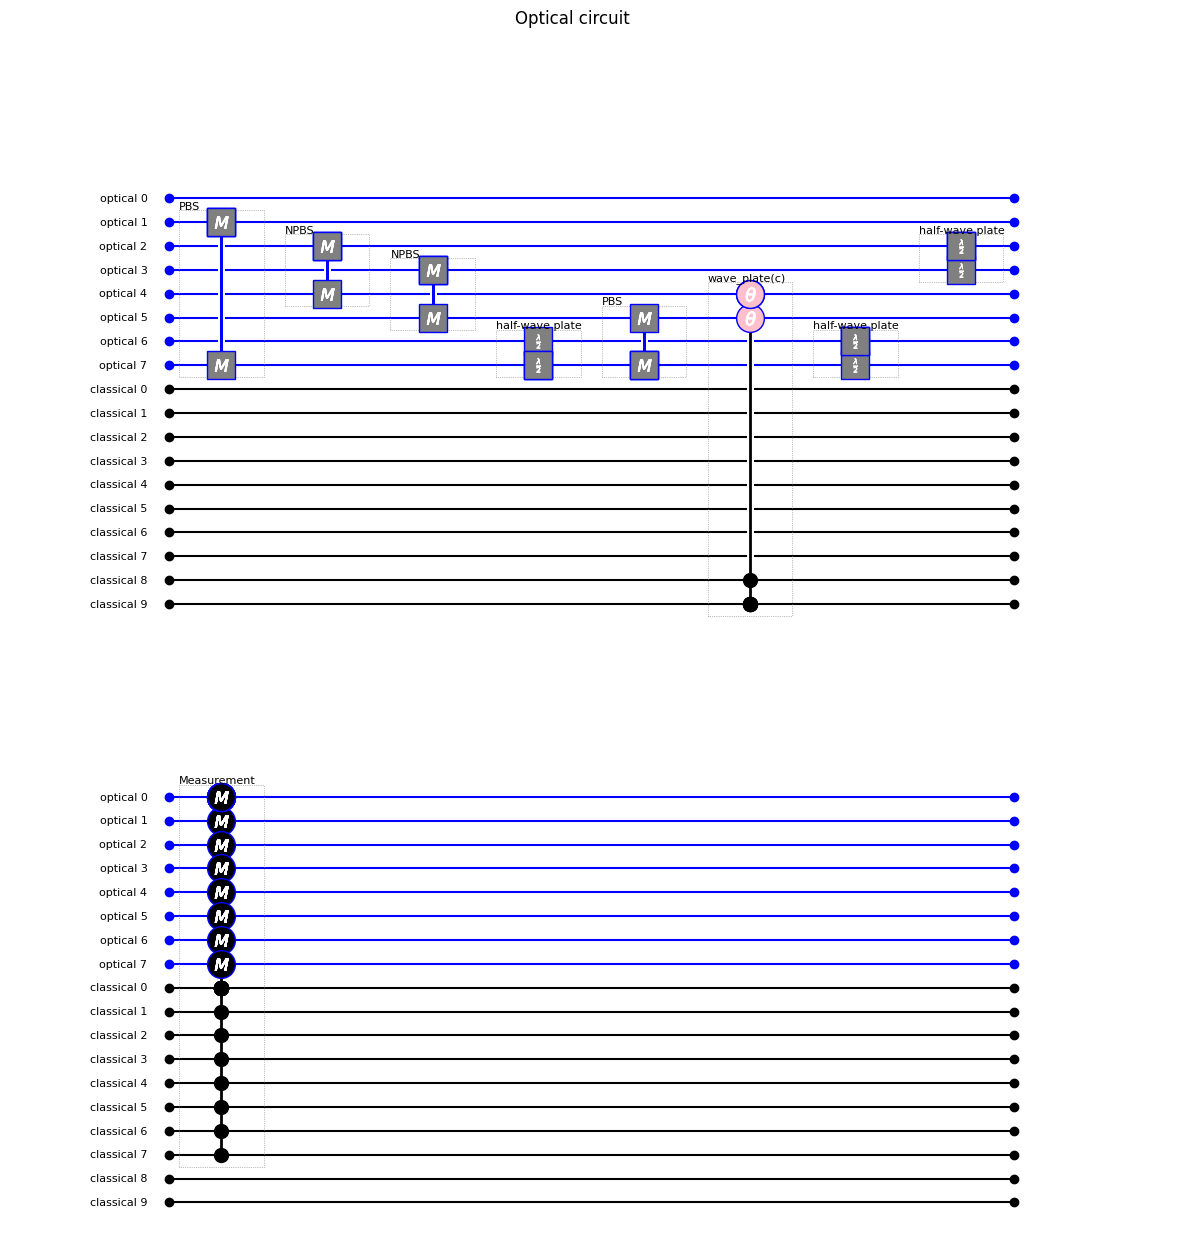

In [3]:
# Start in basis $|ah>|av>|bh>|bv>|BSh>|BSv>|PBSh>|PBSv>$

# The polarizing beamsplitter works between channels 0,1 and 6,7 
# (so between channel 'a' and the PBS vacuum input)
circuit.polarizing_beamsplitter(input_channels_a=(0,1),input_channels_b=(6,7))

# The non-polarizing beamsplitter in front of detector 3 works between channels 2,3 and 4,5 
# (so between channel 'b' and the BS vacuum input)
circuit.non_polarizing_50_50_beamsplitter(input_channels_a=(2,3),input_channels_b=(4,5))

# We add the half wave plate behind the polarizing beamsplitter
# This is for channels 6 and 7 representing horizontal and vertical polarization for this output of the PBS
circuit.half_wave_plate_225(channel_horizontal=7,channel_vertical=6)

# We add the second non-polarizing beamsplitter mixing the output of the half wave plate and the first non-polarizing beamsplitter
circuit.polarizing_beamsplitter(input_channels_a=(6,7),input_channels_b=(4,5))

# For detector 1 we want to measure at 0 degree polarization angle, and at 45 degree polarization angle.
# We enable this by adding a phase plate which is controlled from the classical channels. In this way the same circuit
# can be used for both set-ups. We use classical channels 8 and 9 to control angle and phase delay respectively.
circuit.wave_plate_classical_control(optical_channel_horizontal=4,
                                     optical_channel_vertical=5,
                                     classical_channel_for_orientation=8,
                                     classical_channel_for_phase_shift=9)

# We add a half wave plate in front of detector 2 at +22.5 degree (to establish polarization rotation over +45 degree)
circuit.half_wave_plate(channel_horizontal=6,channel_vertical=7, angle = math.pi/8)

# We add a half wave plate in front of detector 3 at +22.5 degree 
# (to establish polarization rotation over +45 degree)
circuit.half_wave_plate(channel_horizontal=2,channel_vertical=3, angle = math.pi/8)

# And finally we a measure. 
# We map the optical channels on the classical channels such that the result in the classical channels in the order Th,Tv,D1h,D1,D2,D2,D3h,D3v
circuit.measure_optical_to_classical(optical_channels_to_be_measured=[0,1,2,3,4,5,6,7],classical_channels_to_be_written=[0,1,6,7,2,3,4,5])

# And we can draw a schematic of the circuit
circuit.draw()

Now we have created the circuit we have to prepare the input state. Easiest way to do this is by first initializing a default collection of states for the circuit. We do this by calling `initial_collection_of_states = cos.CollectionOfStates(fock_state_circuit=circuit)`. This collection contains all possible input states with a single optical component. We can filter out the state we are interested in `initial_collection_of_states.get_state(initial_state='11110000').copy()`. This state we can manipulate and ultimately we generate a collection of states consisting of only two input states. 

The two states have the same optical component (corresponding to the state $|11110000>$). The differece between the two input states is in the classical channels 8 and 9 (which set the orientation of polarization for detector 1). For the state 'state_D1at0' these values are such that we detect for D1 horizontal and vertical polarization. For the state 'state_D1at45' we detect for D1 at the diagonal directions +45 degree and -45 degree. Using a controlled phase plate in the circuit means we can evaluate the two settings with one collection of states, rather than having to creat two separate circuits for the two settings.

In [4]:
# Create a collection of states with two states. The optical state is always |'11110000'> 
# but classical channel 8 and 9 create a different orientation of the wave plate in front of detector 1

# First initialize a collection of states for the circuit
initial_collection_of_states = cos.CollectionOfStates(fock_state_circuit=circuit)

# Select the state with the optical component we want to study (|11110000>)
state_D1at0 = initial_collection_of_states.get_state(initial_state='11110000').copy()
state_D1at45 = initial_collection_of_states.get_state(initial_state='11110000').copy()

# Prepare the classical channels with channel 8 and 9 controlling the phase plate in front of detector 1.
# In this case the angle of the wave plate should be zero
state_D1at0.classical_channel_values = [0,0,0,0,0,0,0,0,0,math.pi]
state_D1at0.initial_state = 'state_D1at0'
# In this case the angle of the wave plate should be 22.5 degrees (or pi/8 in radians)
state_D1at45.classical_channel_values = [0,0,0,0,0,0,0,0,math.pi/8,math.pi]
state_D1at45.initial_state = 'state_D1at45'


# Clear the original collection of states (delete all states) and add the two states we prepared as the sole states in the collection
initial_collection_of_states.clear()
initial_collection_of_states.add_state(state_D1at0)
initial_collection_of_states.add_state(state_D1at45)

# The collection now has the two states we prepared, with same optial component but different values in classical channels 8 and 9
# if we run these states trough the circuit they will experience a different setting for the controlled wave plate in front of detector 1
print(initial_collection_of_states)

Printing collection of states
Number of states in collection: 2
Identifier: 'identifier_t'
Initial state: 'state_D1at0'
Cumulative probability: 1.00
Classical values: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '3.14']
Optical components: 
	Component: '11110000' Amplitude: (1.00 - 0.00i), Probability: 1.00
Identifier: 'identifier_4'
Initial state: 'state_D1at45'
Cumulative probability: 1.00
Classical values: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.39', '3.14']
Optical components: 
	Component: '11110000' Amplitude: (1.00 - 0.00i), Probability: 1.00



Finally we are ready to run the simulation by calling `circuit.evaluate_circuit(collection_of_states_input=initial_collection_of_states)`. The result is  collection of states at the output. We are only interested in results where meet three conditions:
* we detect a photon at the Trigger detector (which has to be a horizontally polarized photon).
* we detect a photon at D1 in either the horizontal polarization (for input state 'state_D1at0') or in the diagonal +45 degree polarization (for input state 'state_D1at45')
* we detect a photon at D2 in the -45 degree polarization.
This means we filter on outcomes where we find a '1' in classical channels 0,2 and 5 and a '0' in classical channels 1,3 and 4
We then evaluate what we find for the measurement result from D3 in classical channels  6 and 7. If the simulation corresponds with the actual experiment we would find for 'state_D1at0' and equal distribution between a photon in D3+ and D3- (so equal occurence of a '1' in channels 6 and 7). For the input 'state_D1at45' we expect to only find a photon at D3- (so a '1' in classical channel 7) and never a photon at D3+ (so never a '1' in classical channel 6)

In [5]:
result = circuit.evaluate_circuit(collection_of_states_input=initial_collection_of_states)
result.filter_on_classical_channel(classical_channel_numbers=[0,1,2,3,4,5], values_to_filter=[1,0,1,0,0,1])
print(result)

Printing collection of states
Number of states in collection: 3
Identifier: 'identifier_t-M1q'
Initial state: 'state_D1at0'
Cumulative probability: 0.03
Classical values: ['1.00', '0.00', '1.00', '0.00', '0.00', '1.00', '1.00', '0.00', '0.00', '3.14']
Last measurement result:  
	Value: ['1.00', '0.00', '1.00', '0.00', '0.00', '1.00', '1.00', '0.00', '0.00', '3.14'], Probability: 0.03
Optical components: 
	Component: '10101001' Amplitude: (1.00 - 0.00i), Probability: 1.00
Identifier: 'identifier_t-M1r'
Initial state: 'state_D1at0'
Cumulative probability: 0.03
Classical values: ['1.00', '0.00', '1.00', '0.00', '0.00', '1.00', '0.00', '1.00', '0.00', '3.14']
Last measurement result:  
	Value: ['1.00', '0.00', '1.00', '0.00', '0.00', '1.00', '0.00', '1.00', '0.00', '3.14'], Probability: 0.03
Optical components: 
	Component: '10011001' Amplitude: (-1.00 + 0.00i), Probability: 1.00
Identifier: 'identifier_4-M1u'
Initial state: 'state_D1at45'
Cumulative probability: 0.06
Classical values: ['1

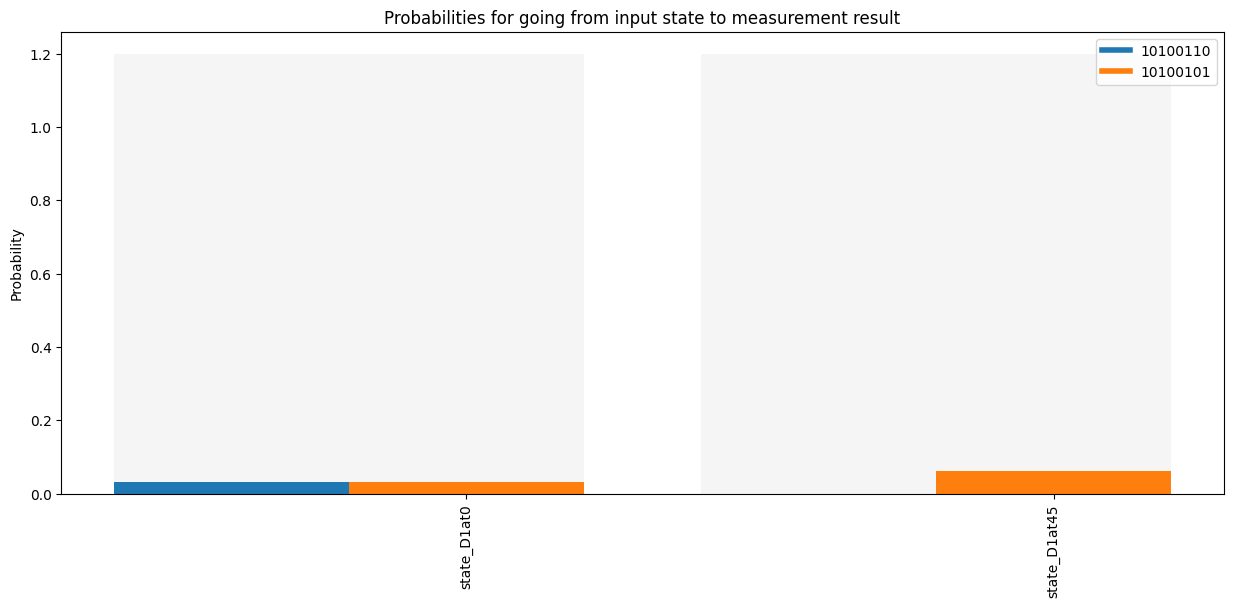

In [6]:
result.plot(classical_channels=[0,1,2,3,4,5,6,7])

The result is as we expect. For D1 at 0 degree we find photons in both polarization directions of detector 3, and for D1 at 45 degree we see the diagonal polarization for detector 3 to be identical to the diagonal polarization at detector 2. We have replicate the experimental results!!

## Have we created a GHZ state?
We have seen that in out simulation we can create the same measurement statistics as reported for the original experiment. In the original article this measurememt statistics is used to underpin the claim that a 'GHZ' state has been created. Specifically, the state $\frac{1}{\sqrt{2}}\cdot(|H_{1}H_{2}V_{3}> + |V_{1}V_{2}H_{3}>)$. If this would be the case it would mean that the optical system would transform the input stated (which is a pure state) in to the mentioned GHZ state (which is also a pure state). This should be a reversible, unitary transformation. 

What we observe in out simulation is that we detect the expected correlations only in 6% of the runs. If we would have a GHZ state we should find the correlation in 100% of the cases. We can wonder what happens in the other 94% and what components of the state are responsible for these outcomes.

The key step we take to reduce the occurence is the filtering. We specifically filter out situations where on photon hits the trigger, and one photon each of detectors 1,2 and 3. In practice we can however have outcomes where multiple photons hit the different detectors. Let's evaluate the outcomes for 'state_D1at45' without the filtering and  without the waveplates in front of the detector. We 'simply' determine the optical components in the output state in the basis $|Th>|Tv>|D3h>|D3v>|D1h>|D1v>|D2h>|D2v>$. If there is a pure GHZ state we should only find components $|10011010>$ and $|10100101>$.

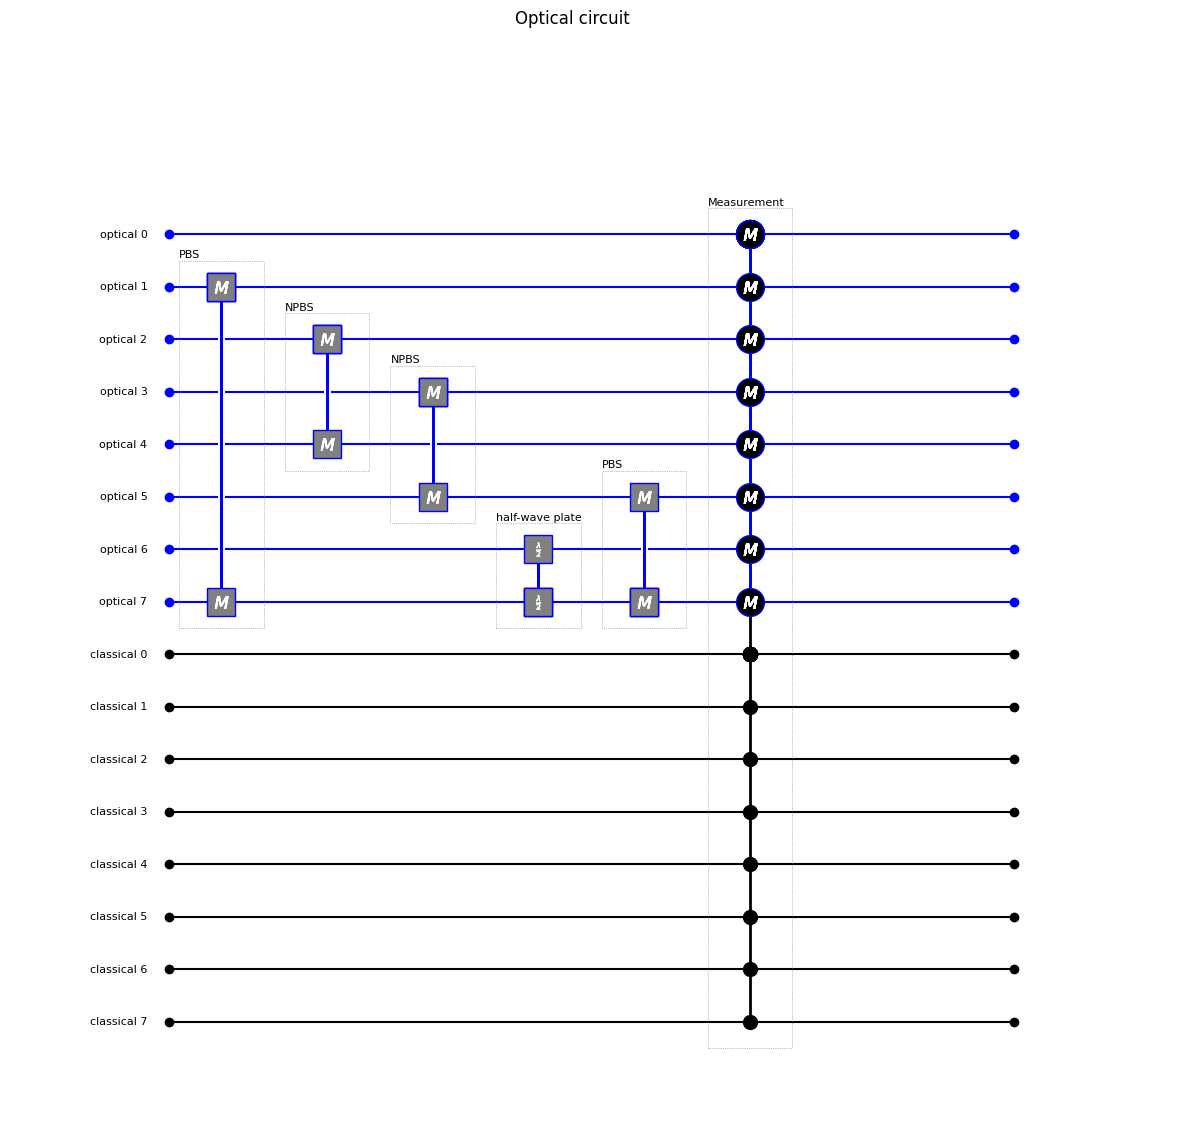

In [7]:
# Initialize a FockStateCircuit with 8 optical channels and maximum 2 photons per channel (so photon count can be 0,1 or 2 photons in a single channel)
# We use 8 classical channels s do not need to manipulate any phase plates
circuit = fsc.FockStateCircuit(length_of_fock_state = 3, 
                                no_of_optical_channels = 8,
                                no_of_classical_channels=8
                                )

# Start in basis $|ah>|av>|bh>|bv>|BSh>|BSv>|PBSh>|PBSv>$

# The polarizing beamsplitter works between channels 0,1 and 6,7 
# (so between channel 'a' and the PBS vacuum input)
circuit.polarizing_beamsplitter(input_channels_a=(0,1),input_channels_b=(6,7))

# The non-polarizing beamsplitter in front of detector 3 works between channels 2,3 and 4,5 
# (so between channel 'b' and the BS vacuum input)
circuit.non_polarizing_50_50_beamsplitter(input_channels_a=(2,3),input_channels_b=(4,5))

# We add the half wave plate behind the polarizing beamsplitter
# This is for channels 6 and 7 representing horizontal and vertical polarization for this output of the PBS
circuit.half_wave_plate_225(channel_horizontal=7,channel_vertical=6)

# We add the second non-polarizing beamsplitter mixing the output of the half wave plate and the first non-polarizing beamsplitter
circuit.polarizing_beamsplitter(input_channels_a=(6,7),input_channels_b=(4,5))
 
# We map the optical channels on the classical channels such that the result in the classical channels in the order Th,Tv,D1h,D1,D2,D2,D3h,D3v
circuit.measure_optical_to_classical(optical_channels_to_be_measured=[0,1,2,3,4,5,6,7],classical_channels_to_be_written=[0,1,6,7,2,3,4,5])

# And we can draw a schematic of the circuit
circuit.draw()

In [8]:
# Create a collection of states with one single state. The optical state is |'11110000'> 

# First initialize a collection of states for the circuit
initial_collection_of_states = cos.CollectionOfStates(fock_state_circuit=circuit)

# Select the state with the optical component we want to study (|11110000>)
state_D1at45 = initial_collection_of_states.get_state(initial_state='11110000').copy()
state_D1at45.initial_state = 'state_D1at45'


# Clear the original collection of states (delete all states) and add the one state we prepared.
initial_collection_of_states.clear()
initial_collection_of_states.add_state(state_D1at45)

# The collection now has the single states we prepared.
print(initial_collection_of_states)

Printing collection of states
Number of states in collection: 1
Identifier: 'identifier_a'
Initial state: 'state_D1at45'
Cumulative probability: 1.00
Classical values: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Optical components: 
	Component: '11110000' Amplitude: (1.00 - 0.00i), Probability: 1.00



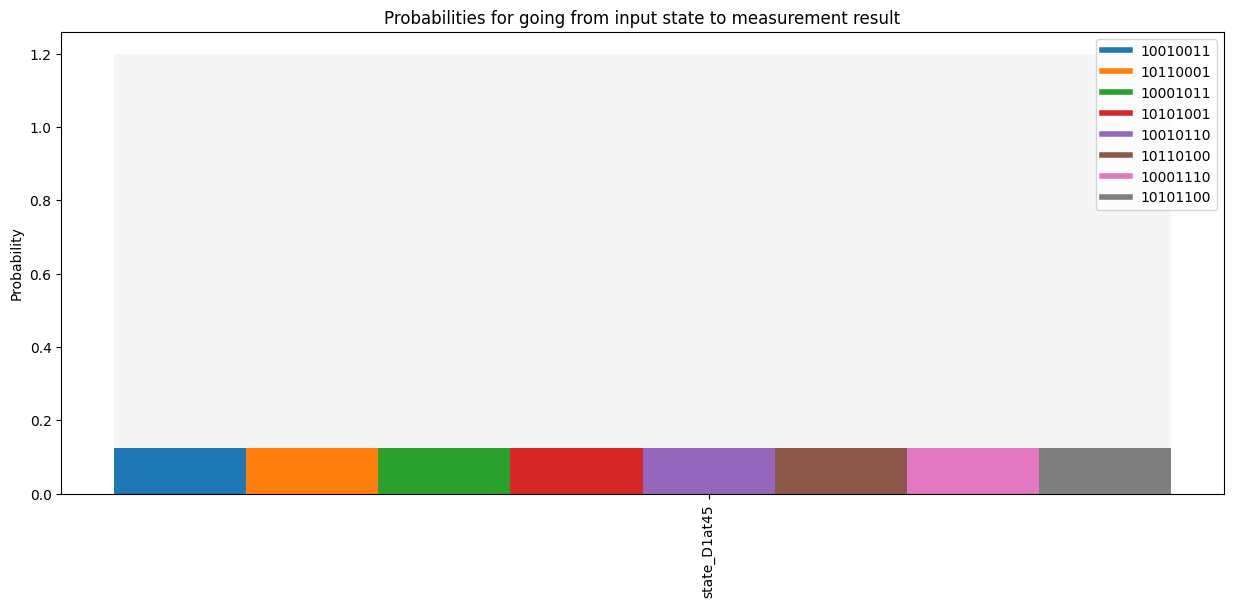

In [9]:
result = circuit.evaluate_circuit(collection_of_states_input=initial_collection_of_states)
result.plot()

We see that we find 8 optical components. All these components have equal probability to occur, so their amplitudes should be equal in the created state. Out of these components 6 have two photons for one detector. We have two components where there is a horizontal and a vertical photon for detector 1, two components where this is the case for detector 2 and two components where this is the case for detector 3. The we have two components where there is only one photon per detector. Only if we exclude the components where we have two photons for a single detector we end up with the GHZ state. 

So after detecting the trigger, rather than generating the state $\frac{1}{\sqrt{2}}\cdot(|H_{1}H_{2}V_{3}> + |V_{1}V_{2}H_{3}>)$ we seem to have generated the state
$\frac{1}{2\sqrt{2}}\cdot(|V_{1}H_{3}V_{3}> + |H_{2}H_{3}V_{3}> + |H_{1}H_{2}V_{2}> + |H_{2}V_{2}H_{3}> + |H_{1}V_{1}V_{2}> + |H_{1}V_{1}V_{3}> + |H_{1}H_{2}V_{3}> + |V_{1}V_{2}H_{3}>)$

Filtering on detection results where we find one photon for each detector leads to the filtering out the first 6 components, and to measurement statistics identical to a GHZ state.